In [1]:
from pyseis.wave_equations import acoustic_isotropic 

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


In [2]:
def vp_model_half_space(n_x,n_z,angle=None):
  vp_model = np.zeros((n_x, n_z))
  vp_model[:, :n_z // 2] = 1500
  vp_model[:, n_z // 2:] = 2500
  if angle is not None:
    vp_model = rotate(vp_model, angle=angle, mode='reflect',reshape=False)
  return vp_model

def ricker(f, length=0.128, dt=0.001):
    t = np.arange(-length/2, (length-dt)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y

## Use AcousticIsotropic2D wave equation with only numpy arrays

Make a half space pressure-wave velocity model. Also make evenly spaced sources and receivers at the surface.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 1.0, 'p-velocity half space')

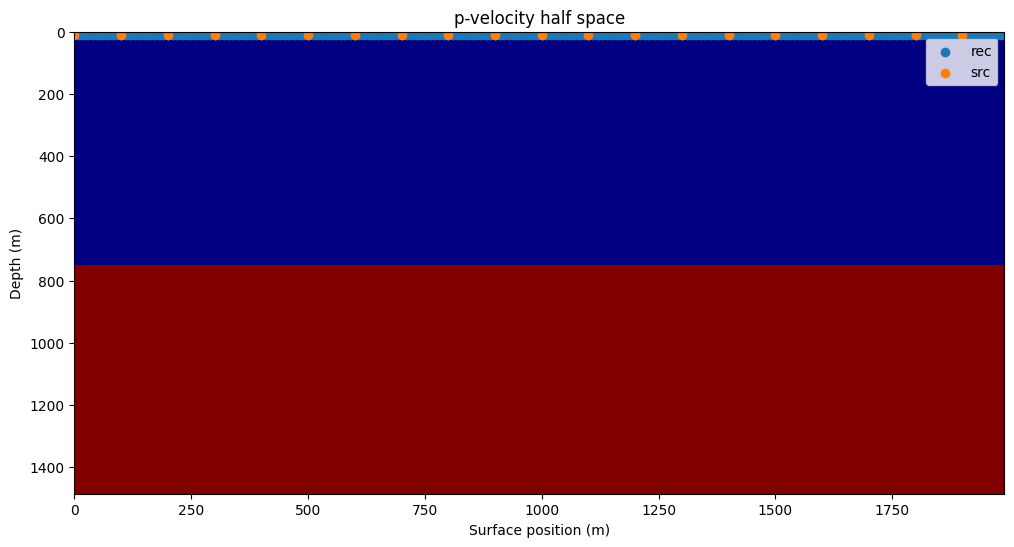

In [3]:
# make model
n_x = 200
d_x = 10.0
n_z = 100
d_z = 15.0
vp_half_space = vp_model_half_space(n_x,n_z,angle=0)

# make evenly spaced source and receiver positions
n_src=20
o_x_src=0.0
d_x_src=n_x*d_x//n_src
z_src=10.0
n_rec=n_x
o_x_rec=0.0
d_x_rec=d_x
z_rec=10.0
src_x_locations = o_x_src + np.arange(n_src) * d_x_src
src_z_locations = np.ones_like(src_x_locations) * z_src
src_locations = np.array([src_x_locations,src_z_locations]).T
rec_x_locations = o_x_rec + np.arange(n_rec) * d_x_rec
rec_z_locations = np.ones_like(rec_x_locations) * z_rec
rec_locations = np.array([rec_x_locations,rec_z_locations]).T

# plot model and src/rec positions
plt.figure(figsize=(12,6))
plt.pcolormesh(np.arange(n_x)*d_x,np.arange(n_z)*d_z,vp_half_space.T,cmap='jet')
plt.gca().invert_yaxis()
plt.scatter(rec_locations[:,0],rec_locations[:,1],label='rec')
plt.scatter(src_locations[:,0],src_locations[:,1],label='src')
plt.legend()
plt.ylabel('Depth (m)')
plt.xlabel('Surface position (m)')
plt.title('p-velocity half space')

Make a Ricker wavelet

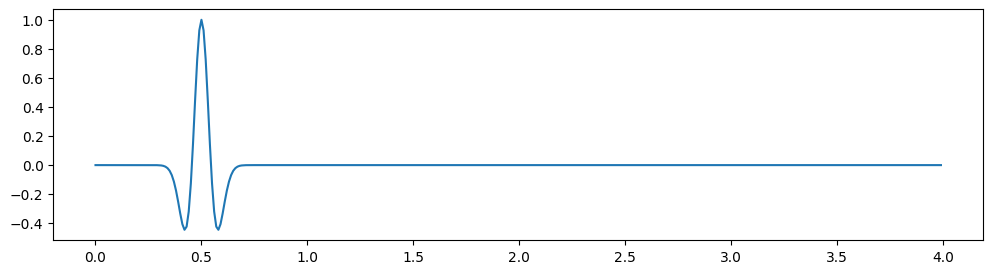

In [4]:
n_t = 400
d_t = 0.01
delay = 0.5
dom_freq = 5.0

t, wavelet_arr = ricker(dom_freq,length=n_t*d_t,dt=d_t)
t -= t[0]
shift = int(delay/d_t) - n_t//2
wavelet_arr = np.roll(wavelet_arr, shift)

plt.figure(figsize=(12,3))
plt.plot(t,wavelet_arr)

In [6]:
acoustic_2d = acoustic_isotropic.AcousticIsotropic2D(model=vp_half_space,
               model_sampling=(d_x, d_z),
               model_padding=(100,100),
               wavelet=wavelet_arr,
               d_t=d_t,
               src_locations=src_locations,
               rec_locations=rec_locations,
               gpus=[0,1,2,3],
               free_surface=True)

In [9]:
%%time
data = acoustic_2d.forward(vp_half_space)

CPU times: user 2.37 s, sys: 1.02 s, total: 3.38 s
Wall time: 1.23 s


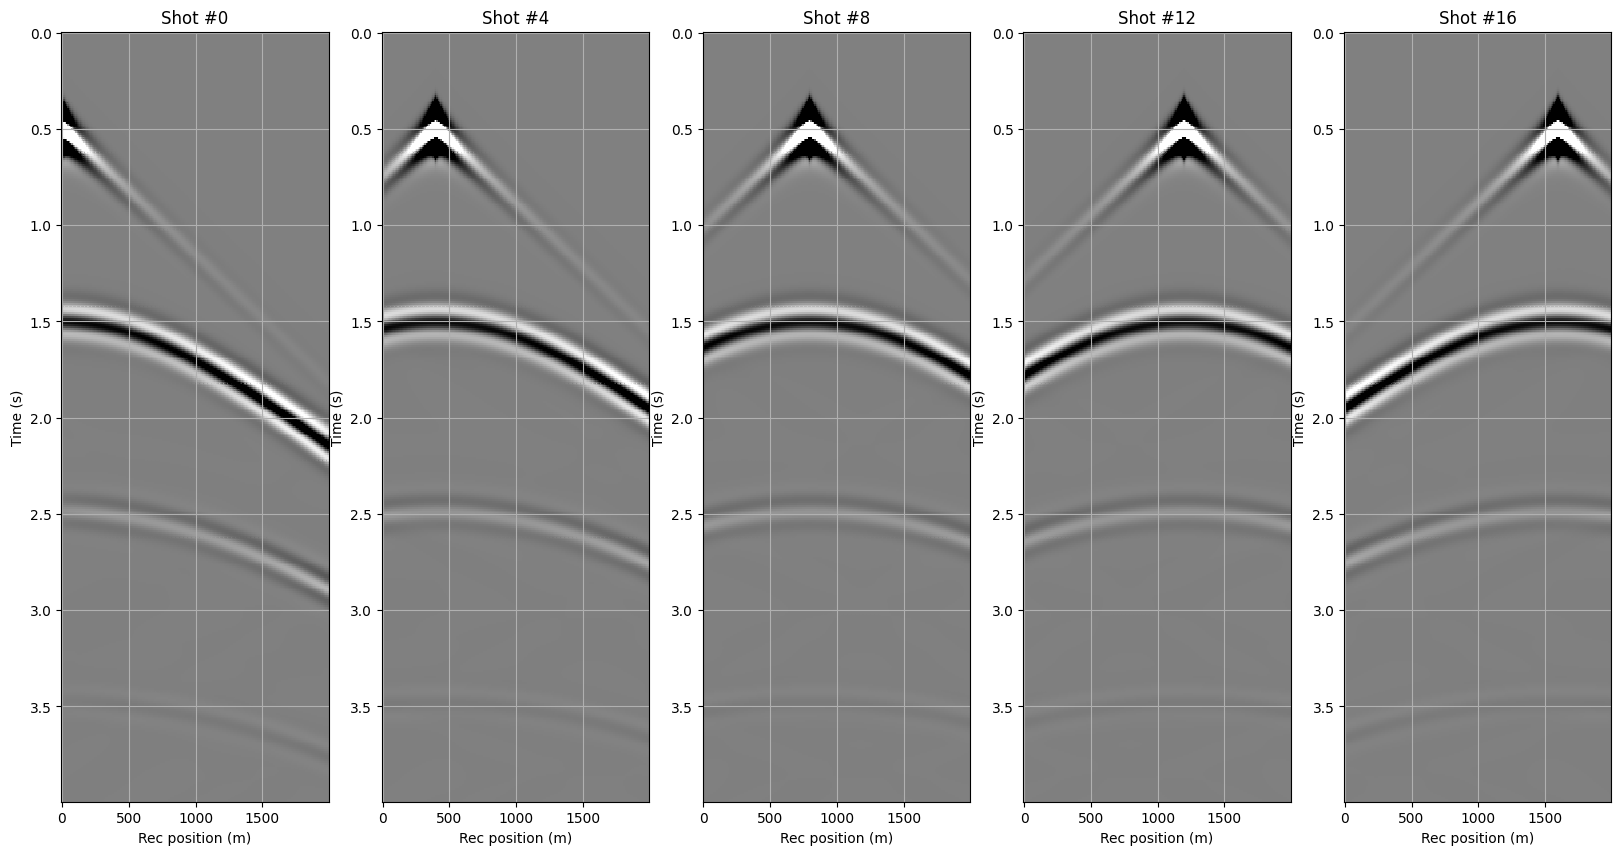

In [10]:
# Display shot gathers
clip = np.percentile(np.abs(data),99)
fig, axs = plt.subplots(1,5, figsize=(20, 10))
shot_skip=4
for shot_number, (ax, shot) in enumerate(zip(axs,data[::shot_skip])):
    ax.pcolormesh(rec_locations[:,0],np.arange(n_t)*d_t,shot.T,cmap='gray',vmin=-clip,vmax=clip,shading='nearest')
    ax.invert_yaxis()
    ax.grid()
    ax.set_ylabel('Time (s)')
    ax.set_xlabel('Rec position (m)')
    ax.set_title(f'Shot #{shot_number*shot_skip}')

## Use AcousticIsotropic2D with Wavelet and Acquisition classes

In [11]:
from pyseis.geometries import Geometry
from pyseis.wavelets.acoustic import Acoustic2D

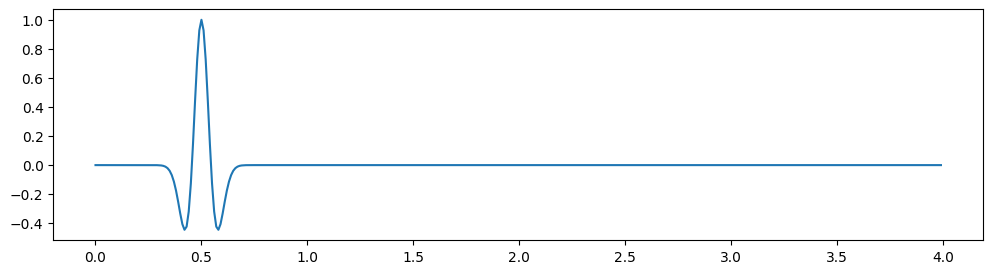

In [12]:
ricker_wavelet = Acoustic2D.AcousticIsotropicRicker2D(n_t,d_t,dom_freq,delay)

full_2d_acquisition = Geometry.Full2D(n_src=n_src,
                                        o_x_src=o_x_src,
                                        d_x_src=d_x_src,
                                        z_src=z_src,
                                        n_rec=n_rec,
                                        o_x_rec=o_x_rec,
                                        d_x_rec=d_x_rec,
                                        z_rec=z_rec)
src_locations = full_2d_acquisition.get_src_positions()
rec_locations = full_2d_acquisition.get_rec_positions()

plt.figure(figsize=(12,3))
plt.plot(np.arange(n_t)*d_t,ricker_wavelet.arr)

In [14]:
acoustic_2d = acoustic_isotropic.AcousticIsotropic2D(model=vp_half_space,
               model_sampling=(d_x, d_z),
               model_padding=(100,100),
               wavelet=ricker_wavelet.arr,
               d_t=d_t,
               src_locations=src_locations,
               rec_locations=rec_locations,
               gpus=[0,1,2,3])
data = acoustic_2d.forward(vp_half_space)

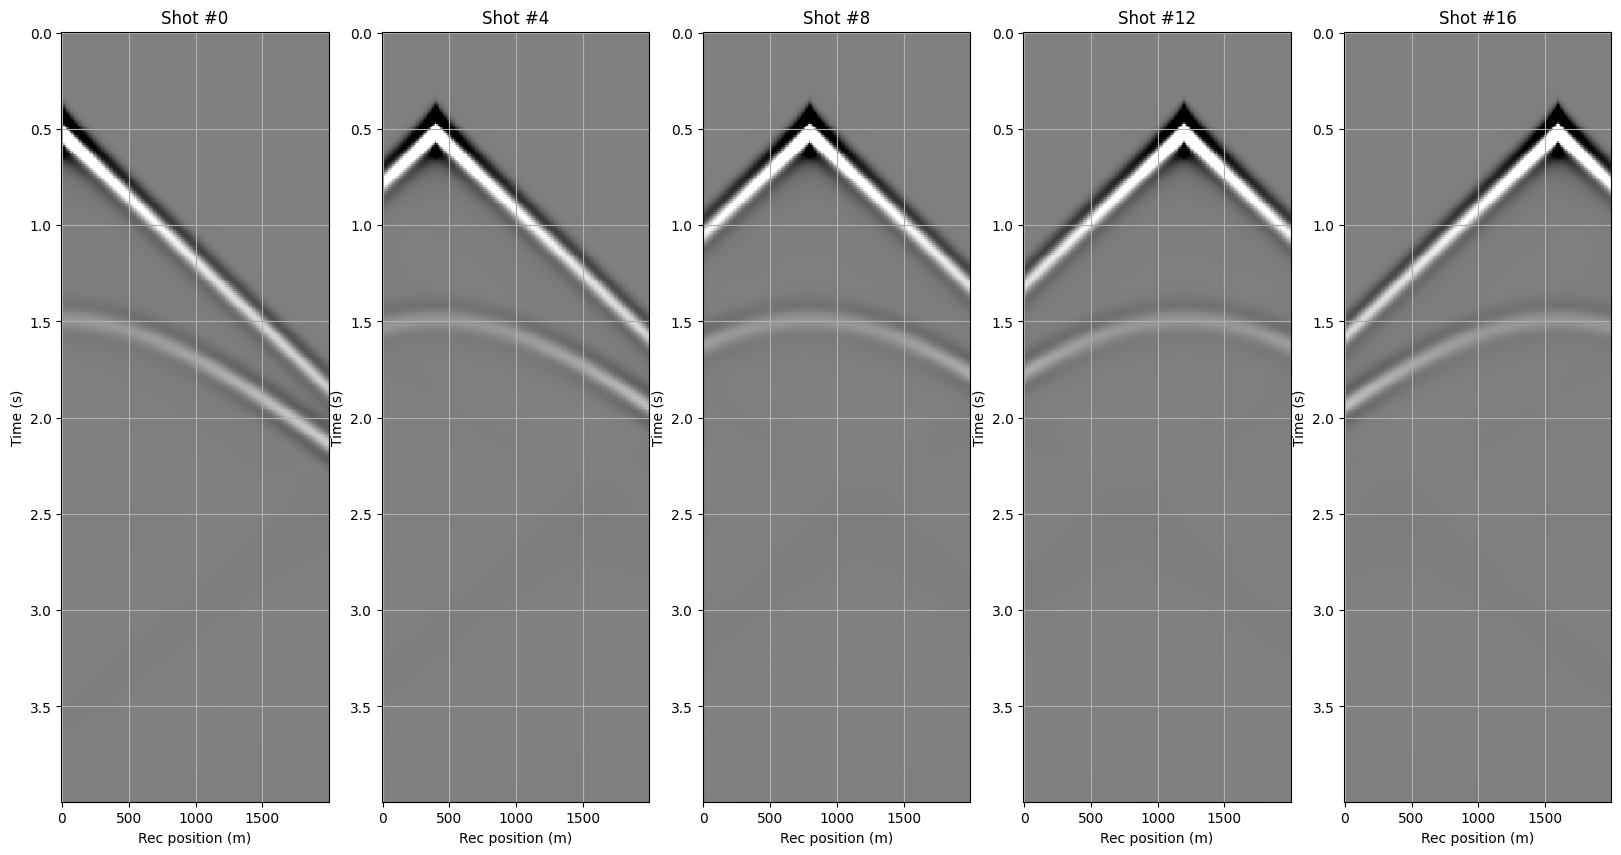

In [15]:
# Display shot gathers
clip = np.percentile(np.abs(data),99)
fig, axs = plt.subplots(1,5, figsize=(20, 10))
shot_skip=4
for shot_number, (ax, shot) in enumerate(zip(axs,data[::shot_skip])):
    ax.pcolormesh(rec_locations[:,0],np.arange(n_t)*d_t,shot.T,cmap='gray',vmin=-clip,vmax=clip,shading='nearest')
    ax.invert_yaxis()
    ax.grid()
    ax.set_ylabel('Time (s)')
    ax.set_xlabel('Rec position (m)')
    ax.set_title(f'Shot #{shot_number*shot_skip}')

## Streamer Acquisition

In [16]:
n_src = 10
n_rec = 75
o_x_rec= -15.0
d_x_rec= -d_x
o_x_src = 1000
streamer_acquisition = Geometry.Streamer2D(n_src=n_src,
                                        o_x_src=o_x_src,
                                        d_x_src=d_x_src,
                                        z_src=z_src,
                                        n_rec=n_rec,
                                        o_x_rec=o_x_rec,
                                        d_x_rec=d_x_rec,
                                        z_rec=z_rec)
src_locations = streamer_acquisition.get_src_positions()
rec_locations = streamer_acquisition.get_rec_positions()

In [20]:
acoustic_2d = acoustic_isotropic.AcousticIsotropic2D(model=vp_half_space,
               model_sampling=(d_x, d_z),
               model_padding=(100,100),
               wavelet=ricker_wavelet.arr,
               d_t=d_t,
               src_locations=src_locations,
               rec_locations=rec_locations,
               gpus=[0,1,2,3])
data = acoustic_2d.forward(vp_half_space)

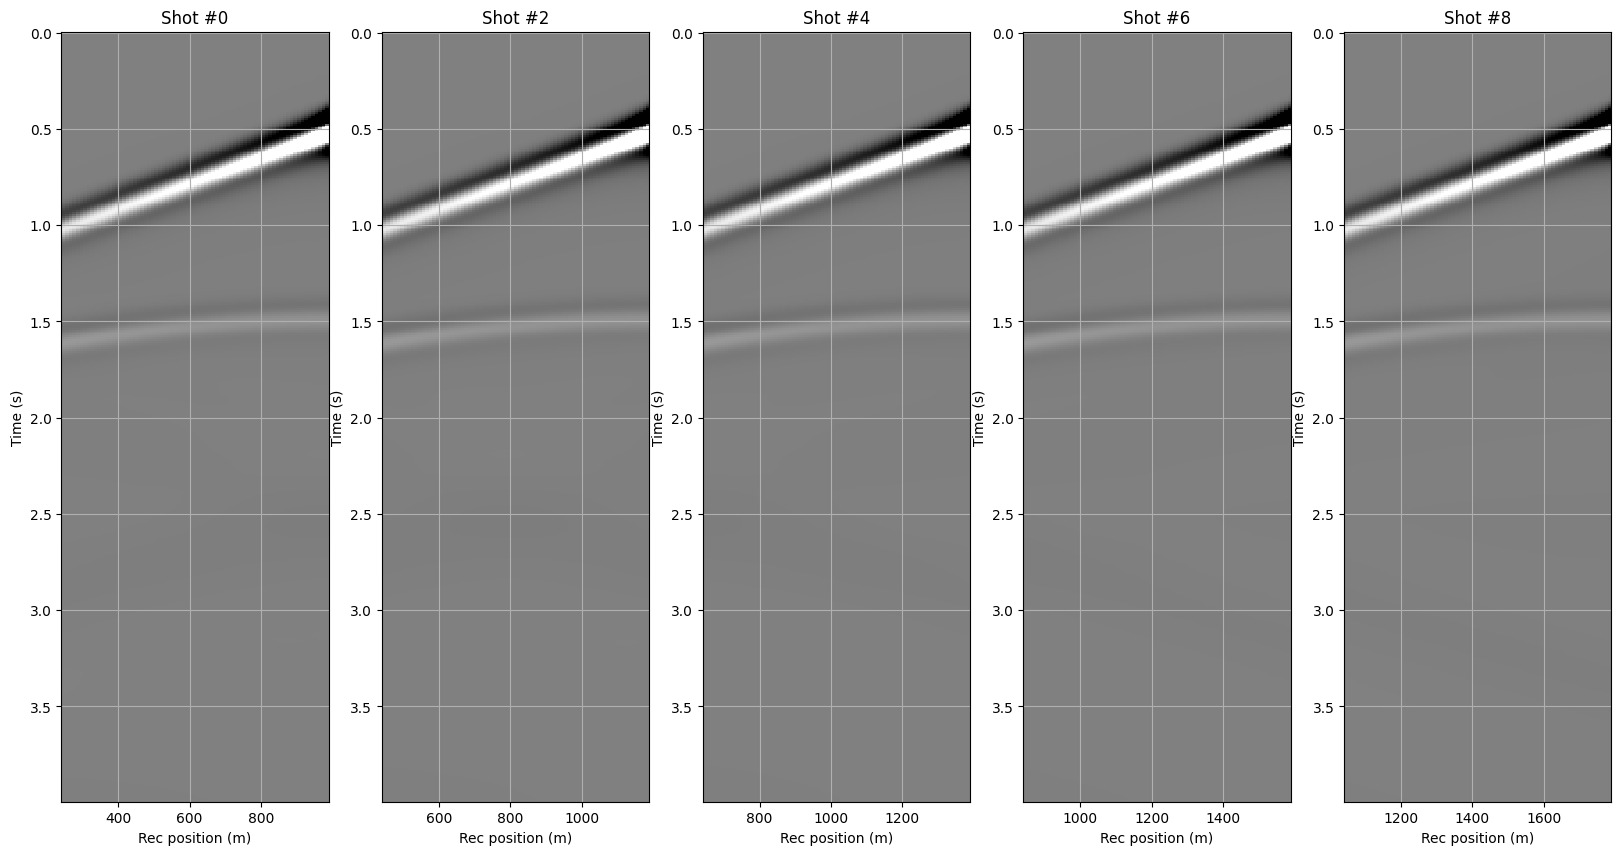

In [21]:
# Display shot gathers
clip = np.percentile(np.abs(data),99)
fig, axs = plt.subplots(1,5, figsize=(20, 10))
shot_skip=2
for shot_number, (ax, shot, rec_loc) in enumerate(zip(axs,data[::shot_skip],rec_locations[::shot_skip])):
    ax.pcolormesh(rec_loc[:,0],np.arange(n_t)*d_t,shot.T,cmap='gray',vmin=-clip,vmax=clip,shading='nearest')
    ax.invert_yaxis()
    ax.grid()
    ax.set_ylabel('Time (s)')
    ax.set_xlabel('Rec position (m)')
    ax.set_title(f'Shot #{shot_number*shot_skip}')